# CS6700 : Programming Assignment - 3
Students:
- Janmenjaya Panda (ME20B087)
- Nishant Sahoo (ME20B122)

In [24]:
# 1 Hierarchical Reinforcement Learning
# For this assignment, we will be referring to Sutton, Precup and Singh’s 1999 paper, ‘Between MDPs and semi-MDPs : A Framework for Temporal Abstraction in Reinforcement
# good reference leading up to the understanding and implementation of SMDP Q-learning.
# Section 3 of the paper talks about SMDP planning and is necessary to build intuition to
# solve this assignment. We will be working with a simple taxi domain environment (explained
# in the next section). Your tasks are to implement 1-step SMDP Q-Learning and intraoption Q-Learning on this environment.
# 2 Environment Description
# The environment for this task is the taxi domain, illustrated in Fig. 1. It is a 5x5 matrix,
# where each cell is a position your taxi can stay at. There is a single passenger who can
# be either picked up or dropped off, or is being transported. There are four designated
# locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the
# episode starts, the taxi starts off at a random square and the passenger is at a random
# location. The taxi drives to the passenger’s location, picks up the passenger, drives to the
# passenger’s destination (another one of the four specified locations), and then drops off the
# passenger. Once the passenger is dropped off, the episode ends.
# There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the
# passenger (including the case when the passenger is in the taxi), and 4 destination locations.
# Note that there are 400 states that can actually be reached during an episode. The missing
# states correspond to situations in which the passenger is at the same location as their
# destination, as this typically signals the end of an episode. Four additional states can be
# observed right after a successful episodes, when both the passenger and the taxi are at the
# destination. This gives a total of 404 reachable discrete states.
# Passenger locations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue); 4: in taxi
# Destinations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue)
# Rewards:
# • -1 per step unless other reward is triggered.
# • +20 delivering passenger.
# • -10 executing ”pickup” and ”drop-off” actions illegally.
# The discount factor is taken to be γ = 0.9.
# 1
# Learning’. Please read the paper upto and including Section 3, it is self explanatory and a
# Programming Assignment 3
# April 6, 2024
# CS6700: Reinforcement Learning
# Figure 1: Taxi Domain
# 3 Actions and Options
# Actions: There are 6 discrete deterministic actions: 0: move south; 1: move north; 2:
# move east; 3: move west; 4: pick passenger up; and 5: drop passenger off.
# Options: Options to move the taxi to each of the four designated locations, executable
# when the taxi is not already there.
# 4 Tasks
# First, implement the single step SMDP Q-learning for solving the taxi problem. A rough
# sketch of the algorithm is as follows: Given the set of options,
# • Execute the current selected option to termination (e.g. use epsilon greedy Q(s, o)).
# • Computer r(s, o).
# • Update Q(st
# , o).
# Second, implement intra-option Q-Learning on the same environment.
# For each algorithm, do the following (only for the configuration with the best hyperparameters):
# 1. Plot reward curves and visualize the learned Q-values.
# 2. Provide a written description of the policies learnt and your reasoning behind why
# the respective algorithm learns the policy.
# 2
# You will be experimenting with Gymnasium Gym’s Taxi-v3 environment.
# 3. Is there an alternate set of options that you can use to solve this problem, such that
# this set and the given options to move the taxi are mutually exclusive? If so, run
# both algorithms with this alternate set of options and compare performance with the
# algorithms run on the options to move the taxi.
# Finally, provide a comparison between the SMDP Q-Learning and intra-option Q-Learning
# algorithms. Do you observe any improvement with intra-option Q-Learning? If so, describe
# why this happens as well. Please make sure that all descriptions are brief and to the point.


In [25]:
# Importing Libraries
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import random
import time
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [26]:
os.makedirs('plots', exist_ok=True)
os.makedirs('hptuning', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [27]:
gamma = 0.9 # Discount Factor

# Defining the Environment
# env = gym.make("Taxi-v3", render_mode="rgb_array")
env = gym.make("Taxi-v3")
# render modes : human, rgb_array, ansi
env.reset()
# env.render()

print("Current State : ", env.s)

# Print number of states and actions
print("Number of States : ", env.observation_space.n)
print("Number of Actions : ", env.action_space.n)

actions = {0 : "South", 1 : "North", 2 : "East", 3 : "West", 4 : "Pickup", 5 : "Dropoff"}

next_state, reward, done, info = env.step(1)
print("Action : ", actions[1])
print("Next State : ", next_state)
print("Reward : ", reward)
print("Done : ", done)
print("Info : ", info)

Current State :  286
Number of States :  500
Number of Actions :  6
Action :  North
Next State :  186
Reward :  -1
Done :  False
Info :  {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}


In [28]:
def decode_state(state):
    row, col, _, _ = env.decode(state)
    return row, col

dest_loc = {"R": [0,0], "G": [0,4], "Y": [4,0], "B": [4,3]}
loc_idx = {"R": 0, "G": 1, "Y": 2, "B": 3, "in_taxi": 4}


In [29]:
def plot_Q(Q, title):
        optimal_action_grid = np.zeros((5, 5)) # stores the optimal action taken for each cell for all the states that have cell as taxi position
        # eg: [0,0] has states from 0-20 ; [0,1] has states from 21-40 and so on
        Q_grid = np.ones((5, 5)) * -1000 # stores the max Q value for each cell for all the states that have cell as taxi position
        state = 0
        while state < 500:
            row, col = decode_state(state)
            Q_grid[row, col] = np.max(Q[state])
            optimal_action_grid[row, col] = np.argmax(Q[state])
            for i in range(20):
                # if Q_grid[row, col] < np.max(Q[state + i]):
                #     Q_grid[row, col] = np.max(Q[state + i])
                #     optimal_action_grid[row, col] = np.argmax(Q[state + i])
                Q_grid[row, col] = np.max(Q[state + i])
                optimal_action_grid[row, col] = np.argmax(Q[state + i])
            state += 20

        plt.figure(figsize=(10, 10))
        plt.imshow(Q_grid, cmap='coolwarm')

        # Add annotations
        for i in range(5):
            for j in range(5):
                action = optimal_action_grid[i, j]
                if action == 0: # put down arrow
                    plt.text(j, i, u'\u2193', color='black', fontsize=20, ha='center', va='center')
                elif action == 1: # put up arrow
                    plt.text(j, i, u'\u2191', color='black', fontsize=20, ha='center', va='center')
                elif action == 2: # put right arrow
                    plt.text(j, i, u'\u2192', color='black', fontsize=20, ha='center', va='center')
                elif action == 3: # put left arrow
                    plt.text(j, i, u'\u2190', color='black', fontsize=20, ha='center', va='center')
                elif action == 4: # put Pick
                    plt.text(j, i, "Pick", color='black', fontsize=20, ha='center', va='center')
                elif action == 5: # put Drop
                    plt.text(j, i, "Drop", color='black', fontsize=20, ha='center', va='center')

        plt.axhline(y=-0.5, color='black', linewidth=3)
        plt.axhline(y=4.5, color='black', linewidth=3)
        plt.axvline(x=-0.5, color='black', linewidth=3)
        plt.axvline(x=4.5, color='black', linewidth=3)

        # Add horizontal grid lines
        for i in range(6):
            plt.axhline(y=i-0.5, color='black', linewidth=1)

        # Add vertical grid lines
        for i in range(6):
            plt.axvline(x=i-0.5, color='black', linewidth=1)

        plt.axvline(x=1.5, ymin=0.6, ymax=1, color='black', linewidth=3)
        plt.axvline(x=0.5, ymin=0, ymax=0.4, color='black', linewidth=3)
        plt.axvline(x=2.5, ymin=0, ymax=0.4, color='black', linewidth=3)

        plt.colorbar()
        plt.title(title)
        plt.show()

In [30]:
class Plot():
    def __init__(self, env, rewards, Q, name):
        self.env = env
        self.rewards = rewards
        self.Q = Q
        self.name = name

    def visualize_taxi_env(self):
        grid = np.ones((5, 5, 3)) # 5x5 grid with 3 channels for RGB

        taxi_row, taxi_col, pass_idx, dest_idx = self.env.decode(self.env.s)

        grid[0,0] = [1, 0, 0] # Red
        grid[0,4] = [0, 1, 0] # Green
        grid[4,0] = [1, 1, 0] # Yellow
        grid[4,3] = [0, 0, 1] # Blue

        plt.figure(figsize=(10, 10))
        plt.imshow(grid)

        # Add horizontal grid lines
        for i in range(6):
            plt.axhline(y=i-0.5, color='black', linewidth=1)

        # Add vertical grid lines
        for i in range(6):
            plt.axvline(x=i-0.5, color='black', linewidth=1)

        # Add taxi
        plt.text(taxi_col, taxi_row, "T", color="black", fontsize=20, ha="center", va="center")
        # plt.plot(taxi_col, taxi_row, marker='s', markersize=20, color='black')

        # # Add passenger
        pass_states = [(0, 0), (0, 4), (4, 0), (4, 3), (taxi_row, taxi_col)]
        if pass_idx < 4:
            plt.text(pass_states[pass_idx][1], pass_states[pass_idx][0] - 0.3, "P", color="black", fontsize=20, ha="center", va="center")
            # plt.plot(pass_states[pass_idx][1], pass_states[pass_idx][0] - 0.3, marker='P', markersize=20, color='black')
        else:
            plt.text(taxi_col, taxi_row - 0.3, "P", color="black", fontsize=20, ha="center", va="center")
            # plt.plot(taxi_col, taxi_row - 0.3, marker='P', markersize=20, color='black')

        # Add Destination
        plt.text(dest_loc["R"][1], dest_loc["R"][0] + 0.3, "D", color="black", fontsize=20, ha="center", va="center")
        # plt.plot(dest_loc["R"][1], dest_loc["R"][0] + 0.3, marker='D', markersize=20, color='black')

        # Add boundary
        plt.axhline(y=-0.5, color='black', linewidth=3)
        plt.axhline(y=4.5, color='black', linewidth=3)
        plt.axvline(x=-0.5, color='black', linewidth=3)
        plt.axvline(x=4.5, color='black', linewidth=3)

        # +---------+
        # |R: | : :G|
        # | : | : : |
        # | : : : : |
        # | | : | : |
        # |Y| : |B: |
        # +---------+

        # Add the walls
        plt.axvline(x=1.5, ymin=0.6, ymax=1, color='black', linewidth=3)
        plt.axvline(x=0.5, ymin=0, ymax=0.4, color='black', linewidth=3)
        plt.axvline(x=2.5, ymin=0, ymax=0.4, color='black', linewidth=3)
        plt.show()

    def plot_Q(self):
        plot_Q(self.Q, f"{self.name} Q-values")


    def plot_rewards(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.rewards.mean(axis=0), color='blue')
        plt.fill_between(range(self.rewards.shape[1]), self.rewards.mean(axis=0) - self.rewards.std(axis=0), self.rewards.mean(axis=0) + self.rewards.std(axis=0), alpha=0.3, color='blue')
        plt.title(f"{self.name} Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        # plt.grid()
        plt.savefig(f'plots/{self.name}_rewards.png')
        plt.show()

    def plot_running_rewards(self):
        plt.figure(figsize=(10, 6))
        window = 10
        running_rewards = self.moving_average(self.rewards.mean(axis=0), window)
        plt.plot(running_rewards, color='blue')
        fill_std = self.moving_average(self.rewards.std(axis=0), window)
        plt.fill_between(range(len(running_rewards)), running_rewards - fill_std, running_rewards + fill_std, alpha=0.3, color='blue')
        plt.title(f"{self.name} Running Rewards")
        plt.xlabel("Episodes")
        plt.ylabel("MA Reward")
        # plt.grid()
        plt.savefig(f'plots/{self.name}_running_rewards.png')
        plt.show()


    @staticmethod
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    

In [32]:
class Option:
    '''
    An option is tuple of <I, pi, beta> where
    I: initiation set
    pi: policy
    beta: termination set
    '''
    def __init__(self, initiation_set, actions, termination_set, name):
        self.initiation_set = initiation_set  # States where the option can be initiated
        self.actions = actions  # Actions that the option can take
        self.termination_set = termination_set  # States where the option terminates
        self.name = name  # Name of the option for identification
        self.q_values = np.zeros((env.observation_space.n, len(actions))) # Q-values for each state and primitive action

    def act(self, state, epsilon = 0.001): # not needed actually (can use epsilon greedy policy function instead)
        if np.random.rand() < epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.q_values[state])

    def terminal(self, state):
        return state in self.termination_set

    def reset(self):
        self.q_values = np.zeros((500, 4))


# Define the initiation and termination sets for each option
termination_sets = [set() for _ in range(4)] # R, G, Y, B

for state in range(500):
    if list(decode_state(state)) == dest_loc["R"]: # If the taxi is at the red location
        termination_sets[0].add(state)
    if list(decode_state(state)) == dest_loc["G"]:
        termination_sets[1].add(state)
    if list(decode_state(state)) == dest_loc["Y"]:
        termination_sets[2].add(state)
    if list(decode_state(state)) == dest_loc["B"]:
        termination_sets[3].add(state)

initiation_sets = [set(range(500)) - term_set for term_set in termination_sets]

# Define the options
options = [] # List of options: Move_to_R, Move_to_G, Move_to_Y, Move_to_B

for loc, idx in loc_idx.items():
    if loc != "in_taxi":  # Skip the "in_taxi" location
        initiation_set = initiation_sets[idx]
        termination_set = termination_sets[idx]
        option_name = f"Move_to_{loc}"
        option = Option(initiation_set, list(range(4)), termination_set, option_name)
        options.append(option)


In [33]:
print(options[0].termination_set)
print(options[1].termination_set)
print(options[2].termination_set)
print(options[3].termination_set)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
{80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
{400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419}
{460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479}


In [34]:
class Args:
    def __init__(self):
        self.num_episodes = 10000
        self.max_steps = 1000
        self.runs = 5

        self.epsilon0 = 1.0
        self.min_epsilon = 1e-5
        self.epsilon_decay = 0.98
        self.alpha = 0.1
        self.option_alpha = 0.1
        self.gamma = 0.9



In [82]:
class Trainer:
    def __init__(self, env, options, args, algo="smdp"):
        self.env = env
        self.options = options
        self.args = args
        self.algo = algo
    
    def _choose_action(self, Q, state, epsilon):
        # possible_actions_idx contains the 1st 6 actions (primitive actions) and then the indices of the options that has state in the initiation set
        possible_action_idx = [0, 1, 2, 3, 4, 5]
        for idx, option in enumerate(self.options):
            if state in option.initiation_set:
                possible_action_idx.append(self.env.action_space.n + idx)

        if np.random.rand() < epsilon:
            return np.random.choice(possible_action_idx)
        else:
            # return the action with max Q-value but only from the possible actions
            return np.argmax(Q[state][possible_action_idx])

    def train(self):
        rewards = np.zeros((self.args.runs, self.args.num_episodes))
        Qs = np.zeros((self.args.runs, self.env.observation_space.n, self.env.action_space.n + len(self.options)))
        for run in range(self.args.runs):
            if self.algo == "smdp":
                Qs[run], rewards[run] = self.smdp()
            elif self.algo == "intra_option":
                Qs[run], rewards[run] = self.intra_option()
        Q = np.mean(Qs, axis=0)
        return Q, rewards

    # def smdp(env, options, num_episodes=1000, alpha=0.1, epsilon=0.001):
    def smdp(self):
        Q = np.zeros((self.env.observation_space.n, self.env.action_space.n + len(self.options)))
        for opt in self.options:
            opt.reset()
        rewards = []
        for episode in tqdm(range(self.args.num_episodes)):
            state = self.env.reset()
            total_reward = 0
            done = False
            steps = 0
            while not done and steps < self.args.max_steps:
                eps = max(0.5*(0.99**steps), 1e-5)
                steps += 1
                action = self._choose_action(Q, state, eps)

                # if primitive action
                if action < self.env.action_space.n:
                    # Perform regular Q-Learning update
                    next_state, reward, done, _ = self.env.step(action)
                    Q[state][action] += self.args.alpha * (reward + self.args.gamma * np.max(Q[next_state]) - Q[state][action])
                    state = next_state
                    total_reward += reward
                else: # if option
                    option = self.options[action - self.env.action_space.n]
                    initial_state = state
                    option_reward = 0
                    discount = 1
                    optsteps = 0
                    while not option.terminal(state):
                        optact = option.act(state, eps)
                        next_state, reward, done, _ = self.env.step(optact)
                        option_reward += discount * reward
                        discount *= self.args.gamma
                        optsteps += 1
                        # Update the Q-value within the option
                        option.q_values[state][optact] += self.args.alpha * \
                                                        (reward+5*(option.terminal(next_state)) + self.args.gamma * np.max(option.q_values[next_state]) \
                                                         - option.q_values[state][optact])
                        state = next_state

                    # Update the Q-value of the option
                    Q[initial_state][action] += self.args.alpha * (option_reward + discount * np.max(Q[state]) - Q[initial_state][action])
                    total_reward += option_reward
            rewards.append(total_reward)
        return Q, rewards

    def intra_option(self):
        Q = np.zeros((self.env.observation_space.n, self.env.action_space.n + len(self.options)))
        for opt in self.options:
            opt.reset()
        rewards = []
        for episode in tqdm(range(self.args.num_episodes)):
            state = self.env.reset()
            total_reward = 0
            done = False
            steps = 0
            while not done and steps < self.args.max_steps:
                eps = max(0.5*(0.99**steps), 1e-5)
                action = self._choose_action(Q, state, eps)
                steps += 1

                # if primitive action
                if action < self.env.action_space.n:
                    # Perform regular Q-Learning update
                    next_state, reward, done, _ = self.env.step(action)
                    Q[state][action] += self.args.alpha * (reward + self.args.gamma * np.max(Q[next_state]) - Q[state][action])

                    for option in self.options:
                            if action in option.actions:
                                if option.terminal(next_state):
                                    Q[state][self.env.action_space.n + self.options.index(option)] += self.args.alpha * (reward + self.args.gamma * np.max(Q[next_state]) - Q[state][self.env.action_space.n + self.options.index(option)])
                                    # option.q_values[state][action] += self.args.alpha * (reward+5*(option.terminal(next_state)) + self.args.gamma * np.max(option.q_values[next_state]) - option.q_values[state][action])
                                else:
                                    Q[state][self.env.action_space.n + self.options.index(option)] += self.args.alpha * (reward + self.args.gamma * Q[next_state][self.env.action_space.n + self.options.index(option)] - Q[state][self.env.action_space.n + self.options.index(option)])
                                    # option.q_values[state][action] += self.args.alpha * (reward+5*(option.terminal(next_state)) + self.args.gamma * option.q_values[next_state][action] - option.q_values[state][action])
                                option.q_values[state][action] += self.args.alpha * (reward+5*(option.terminal(next_state)) + self.args.gamma * np.max(option.q_values[next_state]) - option.q_values[state][action])

                    state = next_state
                    total_reward += reward

                else:
                    curr_option = self.options[action - self.env.action_space.n]
                    optsteps = 0
                    optact = curr_option.act(state, eps)
                    while not curr_option.terminal(state) and optsteps < 1000:
                        next_state, reward, done, _ = self.env.step(optact)
                        optsteps += 1

                        # Update the Q-value of the primitive action
                        Q[state][optact] += self.args.alpha * (reward + self.args.gamma * np.max(Q[next_state]) - Q[state][optact])
                        # Update the Q-value of all self.options that would have selected the same action
                        for option in self.options:
                            if optact in option.actions:
                                if option.terminal(next_state):
                                    Q[state][self.env.action_space.n + self.options.index(option)] += self.args.alpha * (reward + self.args.gamma * np.max(Q[next_state]) - Q[state][self.env.action_space.n + self.options.index(option)])
                                    # option.q_values[state][optact] += self.args.alpha * (reward+5*(option.terminal(next_state)) + self.args.gamma * np.max(option.q_values[next_state]) - option.q_values[state][optact])
                                else:
                                    Q[state][self.env.action_space.n + self.options.index(option)] += self.args.alpha * (reward + self.args.gamma * Q[next_state][self.env.action_space.n + self.options.index(option)] - Q[state][self.env.action_space.n + self.options.index(option)])
                                    # option.q_values[state][optact] += self.args.alpha * (reward+5*(option.terminal(next_state)) + self.args.gamma * option.q_values[next_state][optact] - option.q_values[state][optact])
                                option.q_values[state][optact] += self.args.alpha * (reward+5*(option.terminal(next_state)) + self.args.gamma * np.max(option.q_values[next_state]) - option.q_values[state][optact])

                        state = next_state
                        total_reward += reward
            rewards.append(total_reward)
        return Q, rewards

### SMDP

In [ ]:
# Hyperparameter Tuning
# SMDP Q-Learning
smdp_args = Args()
alphas = [0.01, 0.05, 0.1, 0.2, 0.5]
best_results = {}
best_reward = -np.inf # best mean reward
for alpha in alphas:
    clear_output(wait=True)
    time.sleep(0.1)
    print(alpha)
    smdp_args.alpha = alpha
    trainer = Trainer(env, options, smdp_args, algo="smdp")
    Q, rewards = trainer.train()
    # rewards = (self.smdp_args.runs, self.smdp_args.num_episodes)
    mean_reward = np.mean(rewards) # (self.smdp_args.num_episodes)
    mean_reward = np.mean(mean_reward) # scalar
    if mean_reward > best_reward:
        best_reward = mean_reward
        best_results = {"alpha": alpha, "rewards": rewards, "Q": Q, "option_Q": [option.q_values for option in trainer.options]}
    print(f"Alpha: {alpha}, Mean Reward: {mean_reward}")
    np.save(f"hptuning/smdp_{alpha}_Q.npy", Q)
    np.save(f"hptuning/smdp_{alpha}_rewards.npy", rewards)
    np.save(f"hptuning/smdp_{alpha}_option_Q.npy", [option.q_values for option in trainer.options])

smdp_args.alpha = best_results["alpha"]

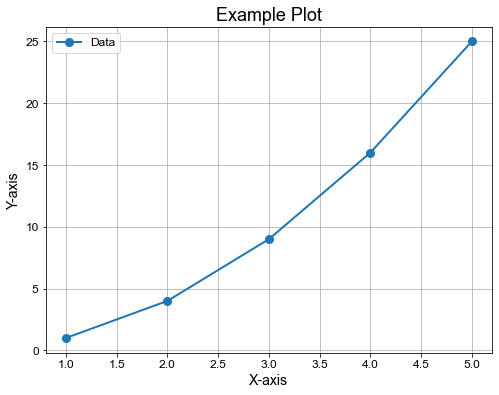

In [60]:
# Customize matplotlib parameters
plt.rcParams['figure.figsize'] = (8, 6)  # Set default figure size
plt.rcParams['axes.titlesize'] = 18      # Set default title font size
plt.rcParams['axes.labelsize'] = 14      # Set default label font size
plt.rcParams['xtick.labelsize'] = 12     # Set default x-axis tick label font size
plt.rcParams['ytick.labelsize'] = 12     # Set default y-axis tick label font size
plt.rcParams['legend.fontsize'] = 12     # Set default legend font size
plt.rcParams['lines.linewidth'] = 2     # Set default line width
plt.rcParams['lines.markersize'] = 8     # Set default marker size
plt.rcParams['font.family'] = 'Arial'    # Set default font family

# Example plot
x = [1, 2, 3, 4, 5]
y = [1, 4, 9, 16, 25]

plt.plot(x, y, marker='o', label='Data')
plt.title('Example Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()


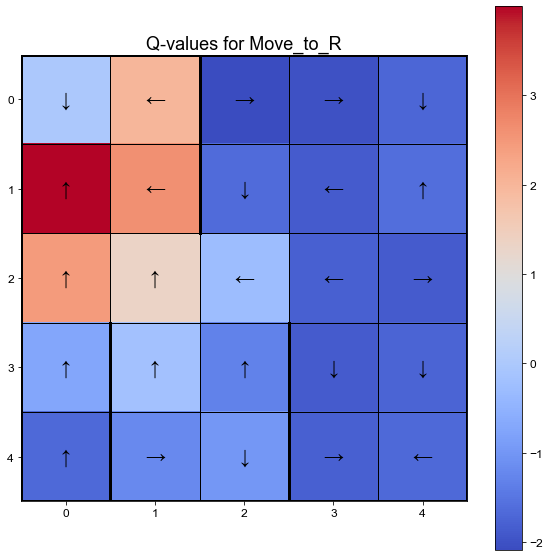

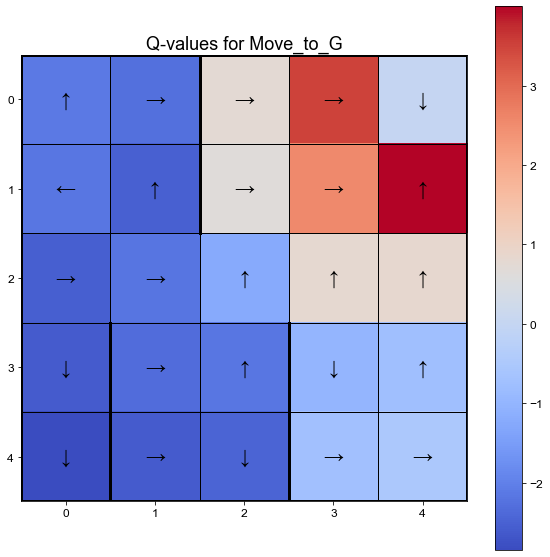

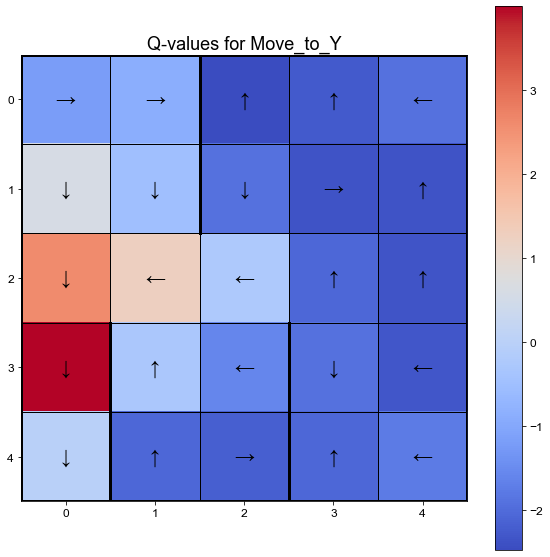

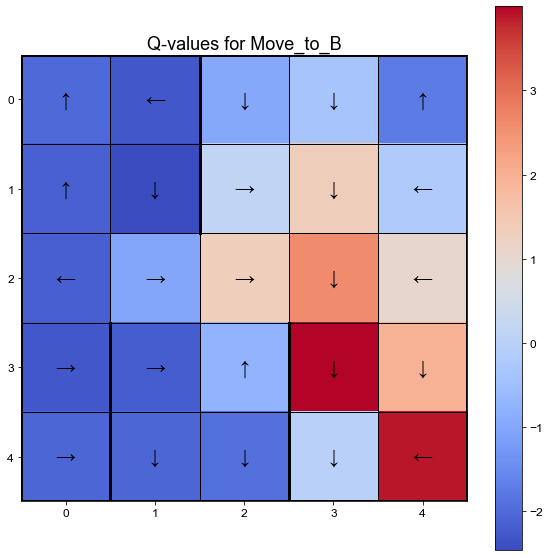

In [61]:
# Load the Q, rewards and option Q-values for best alpha
pp = 0.5
Q_best_alpha = np.load(f"hptuning/smdp_{pp}_Q.npy")
rewards_best_alpha = np.load(f"hptuning/smdp_{pp}_rewards.npy")
option_Q_best_alpha = np.load(f"hptuning/smdp_{pp}_option_Q.npy")

# plot the Q table for the options that I just loaded
for i, option in enumerate(options):
    option_q = option_Q_best_alpha[i]
    plot_Q(option_q, f"Q-values for {option.name}")

100%|██████████| 10000/10000 [03:15<00:00, 51.26it/s]


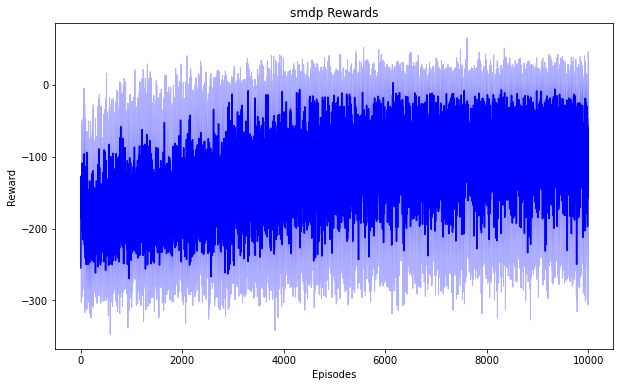

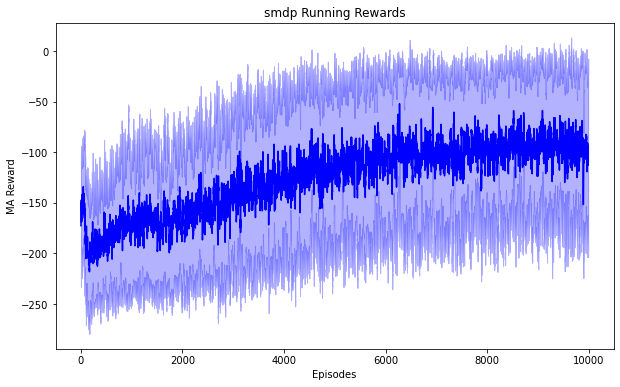

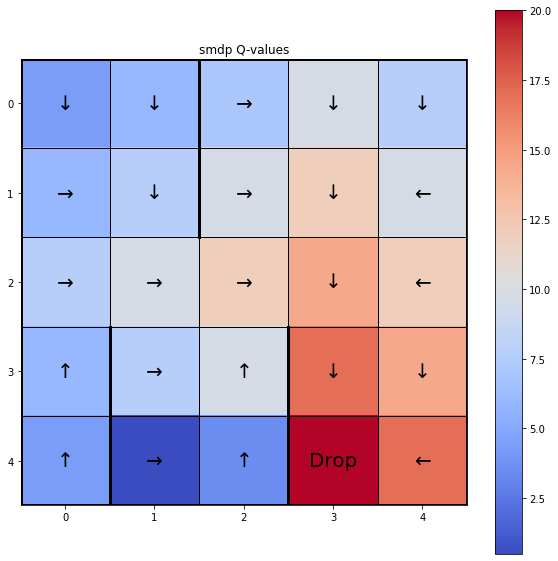

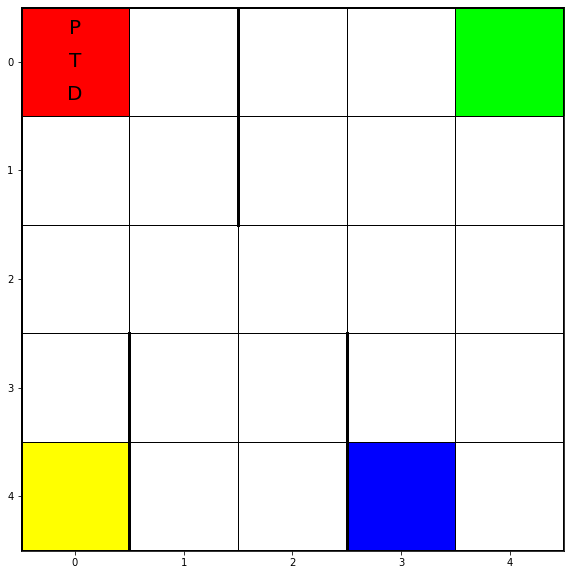

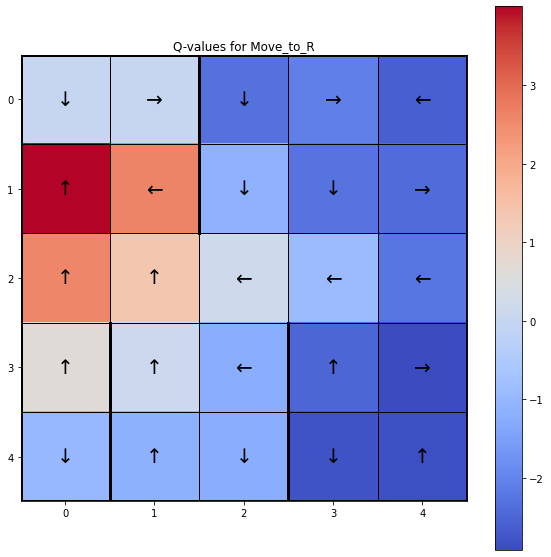

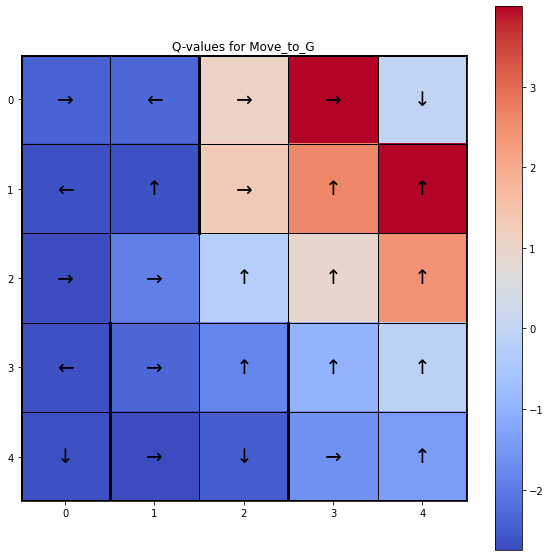

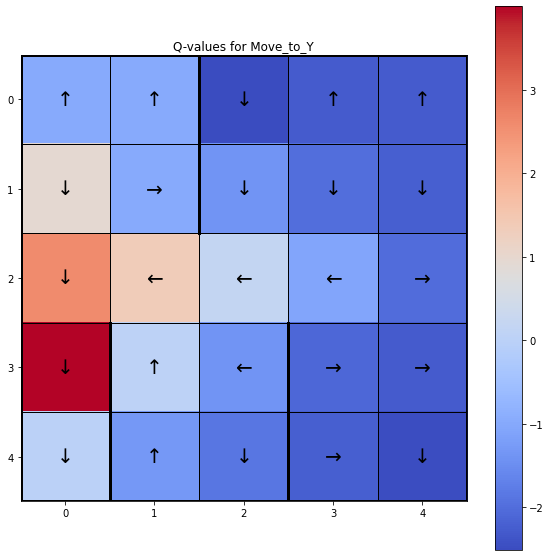

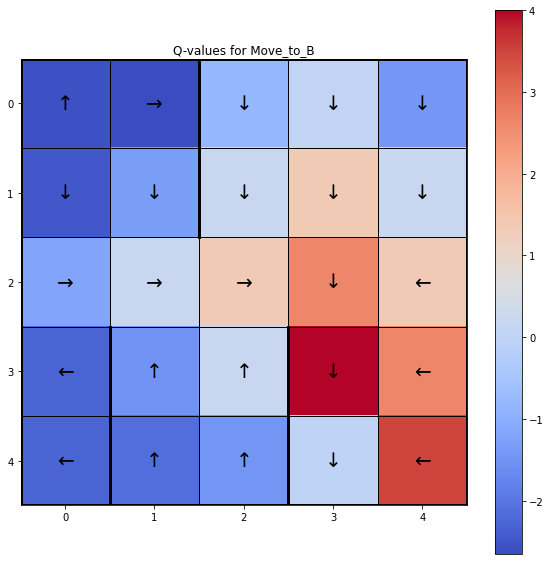

In [36]:
# Implement SMDP Q-Learning
# args = smdp_args
args = Args()
args.alpha = 0.5
smdp_trainer = Trainer(env, options, args, algo="smdp")
Q, rewards = smdp_trainer.train()
np.save("results/smdp_Q.npy", Q)
np.save("results/smdp_rewards.npy", rewards)

Q = np.load("results/smdp_Q.npy")
rewards = np.load("results/smdp_rewards.npy")

plot = Plot(env, rewards, Q, "smdp")
plot.plot_rewards()
plot.plot_running_rewards()
plot.plot_Q()
plot.visualize_taxi_env()

# save Q-Table of options
for i, option in enumerate(smdp_trainer.options):
    np.save(f"results/smdp_{option.name}_Q.npy", option.q_values)

# Plot Q-values for each option
for option in options:
    option_q = np.load(f"results/smdp_{option.name}_Q.npy")
    plot_Q(option_q, f"Q-values for {option.name}")

### Intra-Option

In [ ]:
# Hyperparameter Tuning
# Intra Option Q-Learning

io_args = Args()
alphas = [0.01, 0.05, 0.1, 0.2, 0.5]
best_results = {}
best_reward = -np.inf # best mean reward
for alpha in alphas:
    clear_output(wait=True)
    time.sleep(0.1)
    print(alpha)
    io_args.alpha = alpha
    trainer = Trainer(env, options, io_args, algo="intra_option")
    Q, rewards = trainer.train()
    # rewards = (self.io_args.runs, self.io_args.num_episodes)
    mean_reward = np.mean(rewards) # (self.io_args.num_episodes)
    mean_reward = np.mean(mean_reward) # scalar
    if mean_reward > best_reward:
        best_reward = mean_reward
        best_results = {"alpha": alpha, "rewards": rewards, "Q": Q, "option_Q": [option.q_values for option in trainer.options]}
    print(f"Alpha: {alpha}, Mean Reward: {mean_reward}")
    np.save(f"hptuning/intra_option_{alpha}_Q.npy", Q)
    np.save(f"hptuning/intra_option_{alpha}_rewards.npy", rewards)
    np.save(f"hptuning/intra_option_{alpha}_option_Q.npy", [option.q_values for option in trainer.options])

io_args.alpha = best_results["alpha"]

# # Load the Q, rewards and option Q-values for best alpha
# Q_best_alpha = np.load(f"hptuning/intra_option_{io_args.alpha}_Q.npy")
# rewards_best_alpha = np.load(f"hptuning/intra_option_{io_args.alpha}_rewards.npy")
# option_Q_best_alpha = np.load(f"hptuning/intra_option_{io_args.alpha}_option_Q.npy")

# # plot the Q table for the options that I just loaded
# for i, option in enumerate(options):
#     option_q = option_Q_best_alpha[i]
#     plot_Q(option_q, f"Q-values for {option.name}")

100%|██████████| 10000/10000 [01:13<00:00, 136.95it/s]


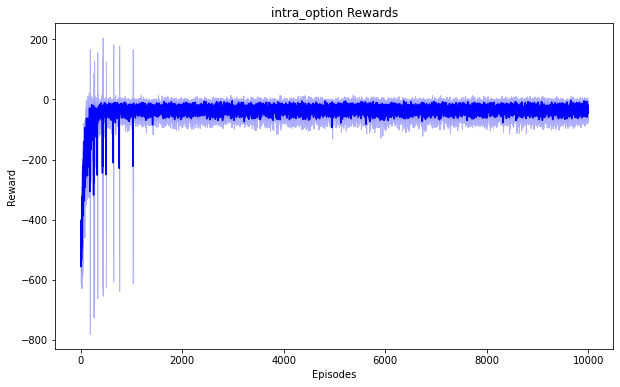

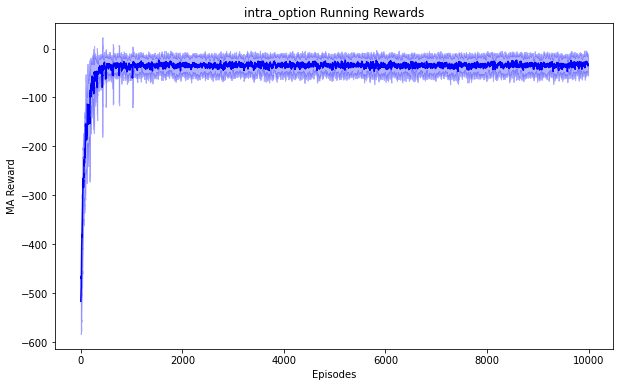

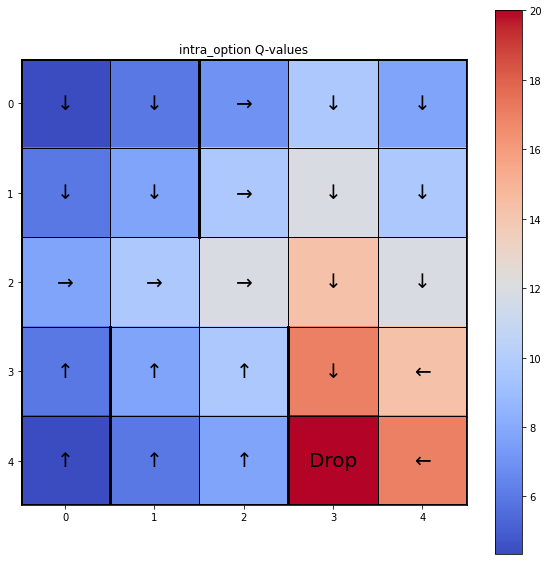

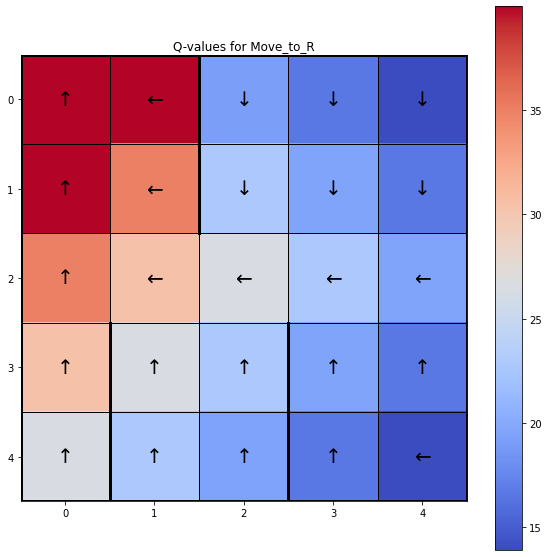

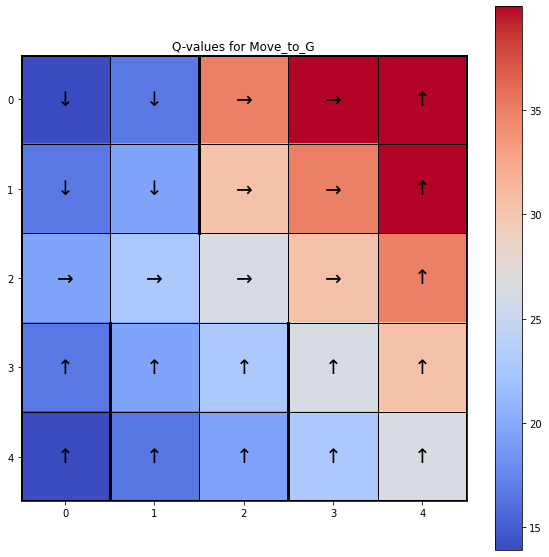

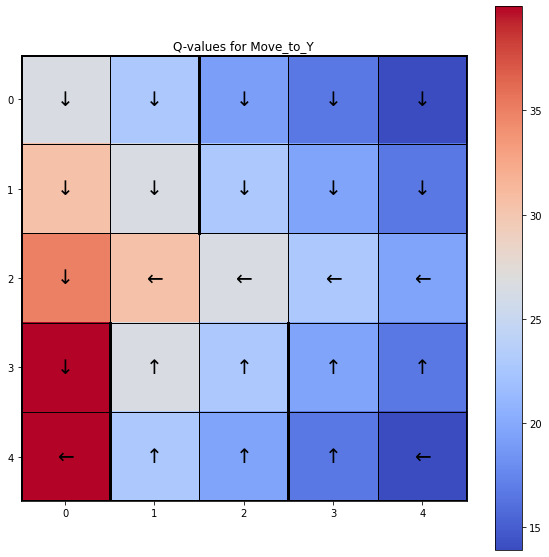

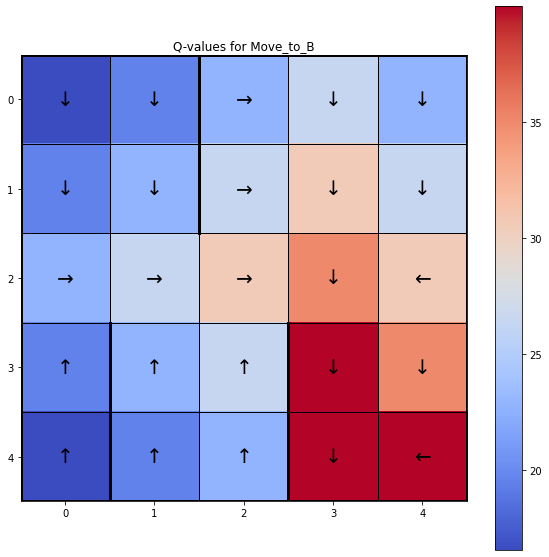

In [41]:
# Implement Intra Option Q-Learning
args = Args()
args.alpha = 0.5
io_trainer = Trainer(env, options, args, algo="intra_option")
Q, rewards = io_trainer.train()
np.save("results/intra_option_Q.npy", Q)
np.save("results/intra_option_rewards.npy", rewards)

Q = np.load("results/intra_option_Q.npy")
rewards = np.load("results/intra_option_rewards.npy")

plot = Plot(env, rewards, Q, "intra_option")
plot.plot_rewards()
plot.plot_running_rewards()
plot.plot_Q()
# plot.visualize_taxi_env()

# Plot Q-Table of options
for i, option in enumerate(io_trainer.options):
    np.save(f"results/intra_option_{option.name}_Q.npy", option.q_values)
    
# Plot Q-values for each option
for option in options:
    option_q = np.load(f"results/intra_option_{option.name}_Q.npy")
    plot_Q(option_q, f"Q-values for {option.name}")

In [ ]:
def plot_running_rewards_together(r1, r2):
    plt.figure(figsize=(10, 6))
    window = 10
    running_rewards1 = moving_average(r1.mean(axis=0), window)
    plt.plot(running_rewards1, color='red', label="SMDP")
    fill_std1 = moving_average(r1.std(axis=0), window)
    plt.fill_between(range(len(running_rewards1)), running_rewards1 - fill_std1, running_rewards1 + fill_std1, alpha=0.2, color='red')
    running_rewards2 = moving_average(r2.mean(axis=0), window)
    plt.plot(running_rewards2, color='blue', label="Intra")
    fill_std2 = moving_average(r2.std(axis=0), window)
    plt.fill_between(range(len(running_rewards2)), running_rewards2 - fill_std2, running_rewards2 + fill_std2, alpha=0.2, color='blue')

    plt.xlabel("Episodes")
    plt.ylabel("MA Reward")
    plt.legend()
    # plt.grid()
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

rewards_smdp = np.load("results/smdp_rewards.npy")
rewards_io = np.load("results/intra_option_rewards.npy")
plot_running_rewards_together(rewards_smdp, rewards_io)

In [ ]:
def plot_together(r1, r2):
    plt.figure(figsize=(10, 6))
    plt.plot(r1.mean(axis=0), color='red', label="SMDP")
    plt.fill_between(range(r1.shape[1]), r1.mean(axis=0) - r1.std(axis=0), r1.mean(axis=0) + r1.std(axis=0), alpha=0.3, color='red')
    plt.plot(r2.mean(axis=0), color='blue', label="Intra")
    plt.fill_between(range(r2.shape[1]), r2.mean(axis=0) - r2.std(axis=0), r2.mean(axis=0) + r2.std(axis=0), alpha=0.3, color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.legend()
    # plt.grid()
    plt.show()

rewards_smdp = np.load("results/smdp_rewards.npy")
rewards_io = np.load("results/intra_option_rewards.npy")
plot_together(rewards_smdp, rewards_io)

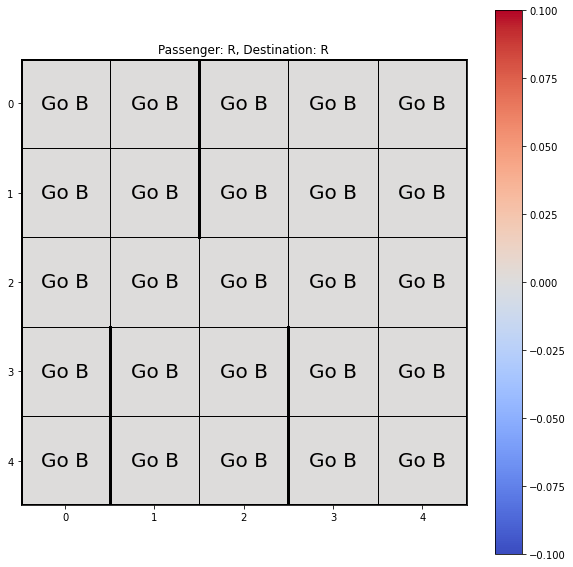

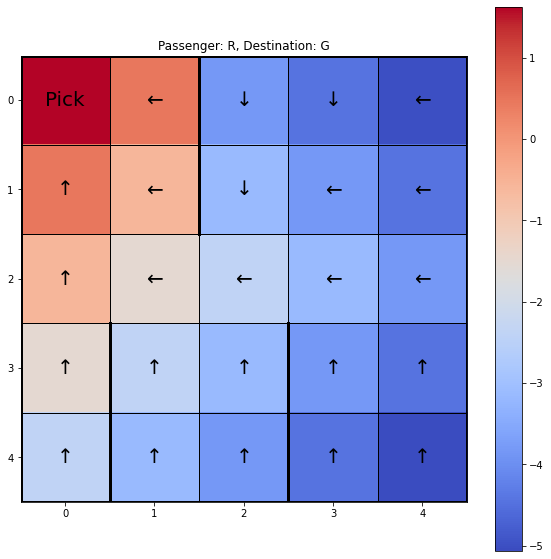

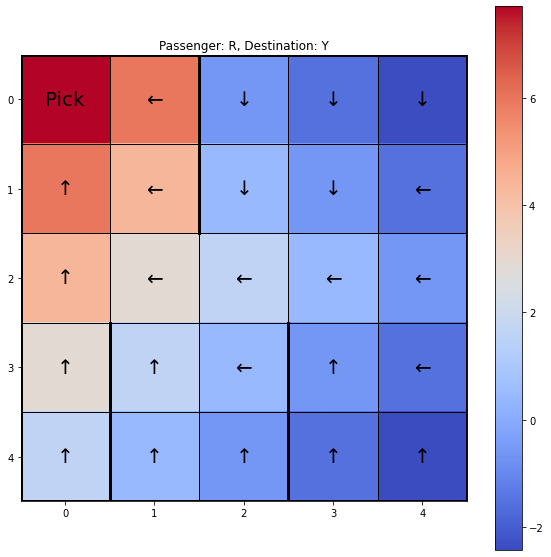

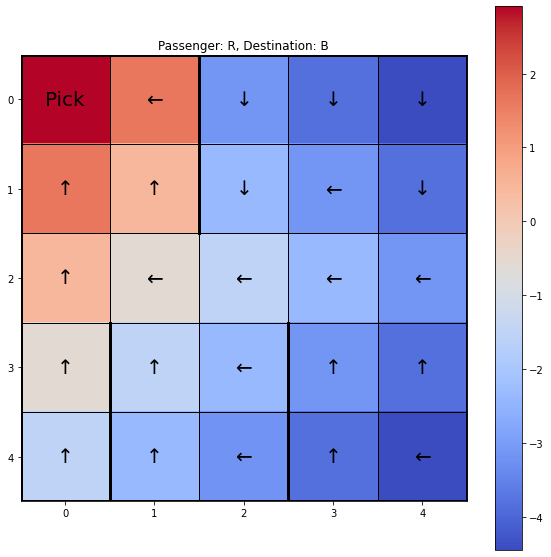

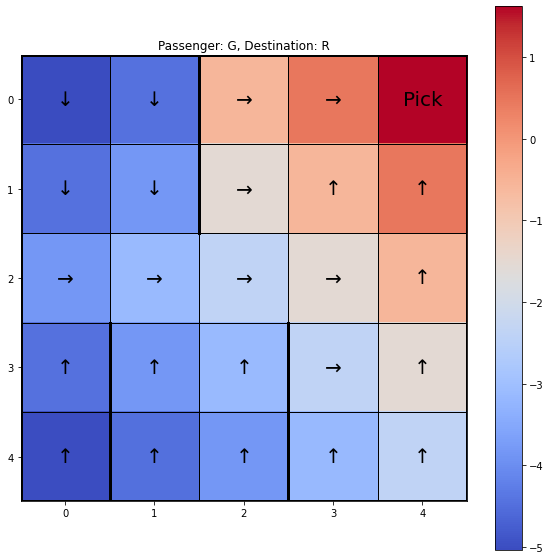

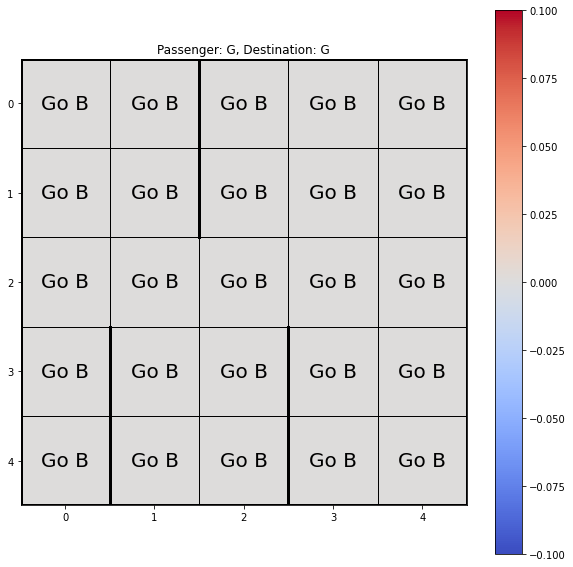

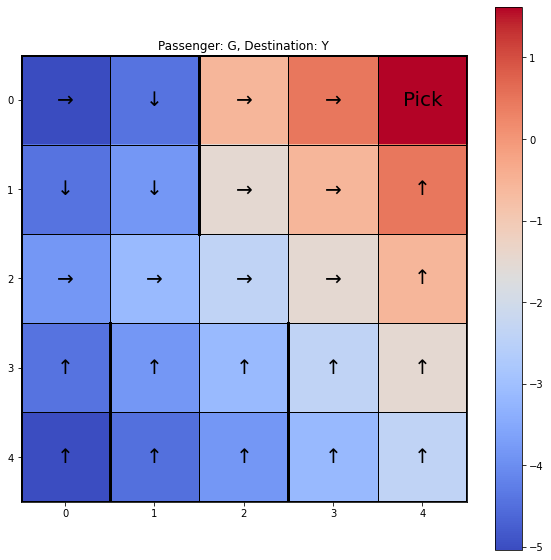

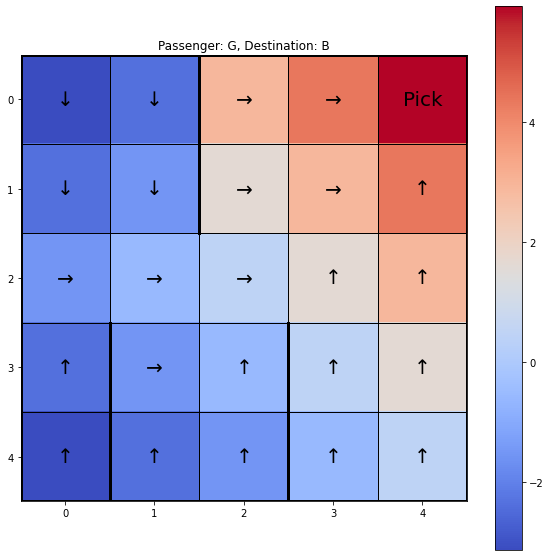

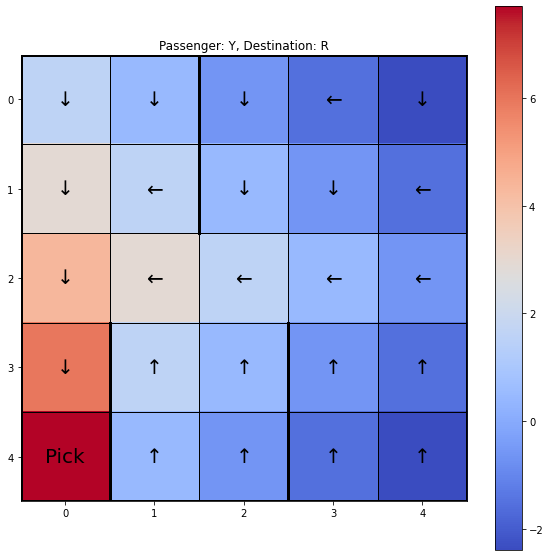

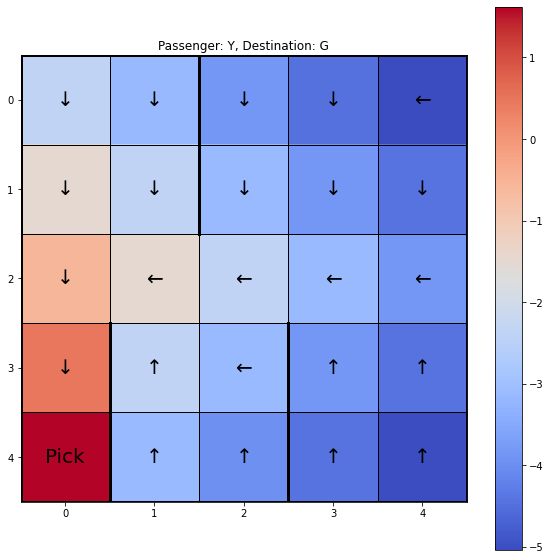

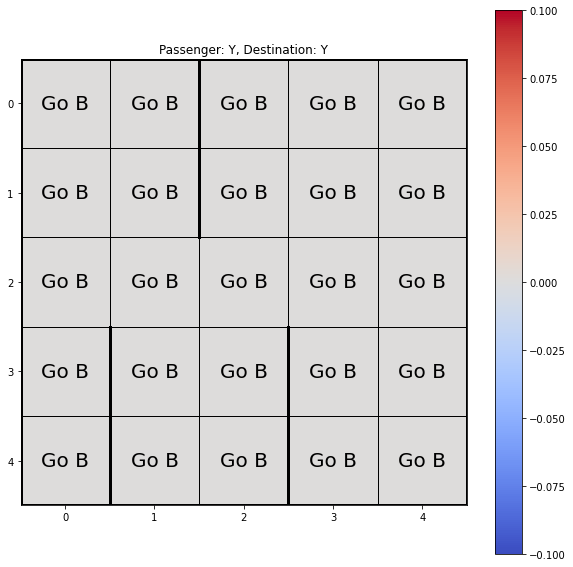

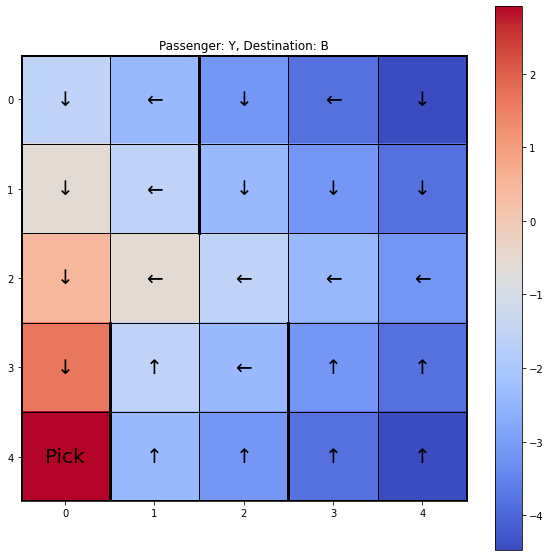

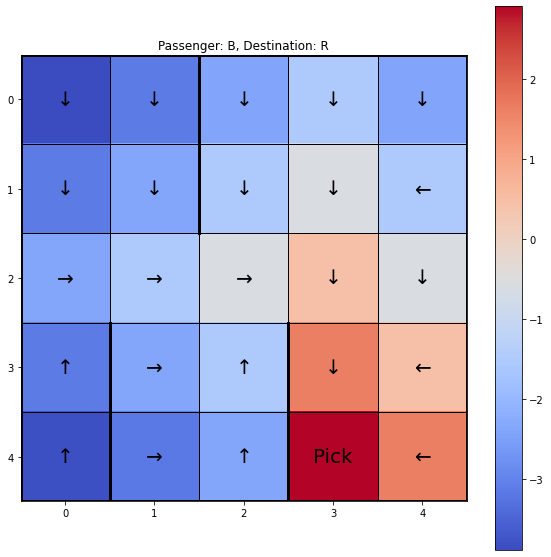

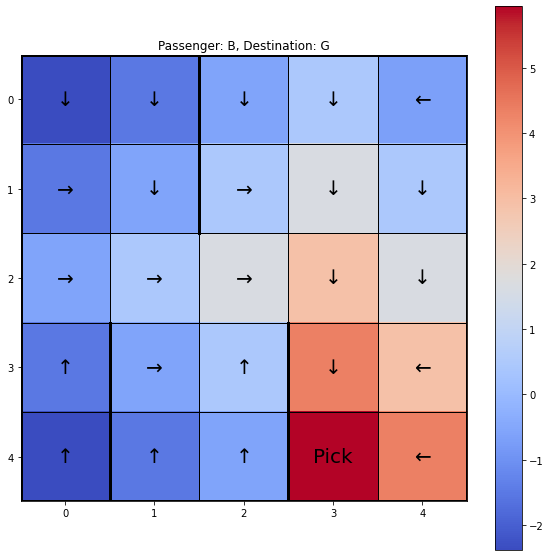

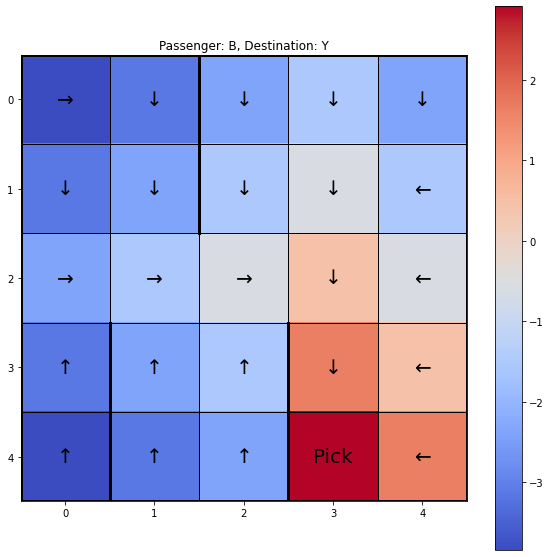

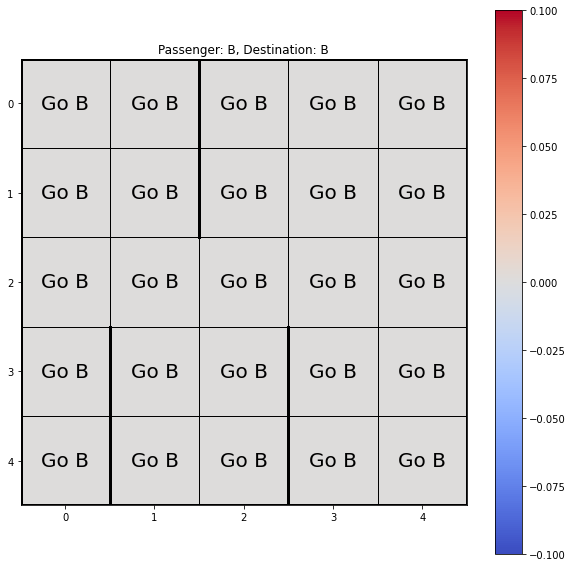

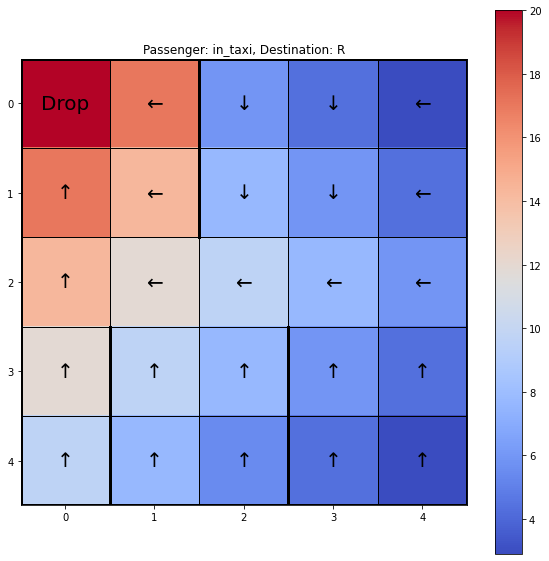

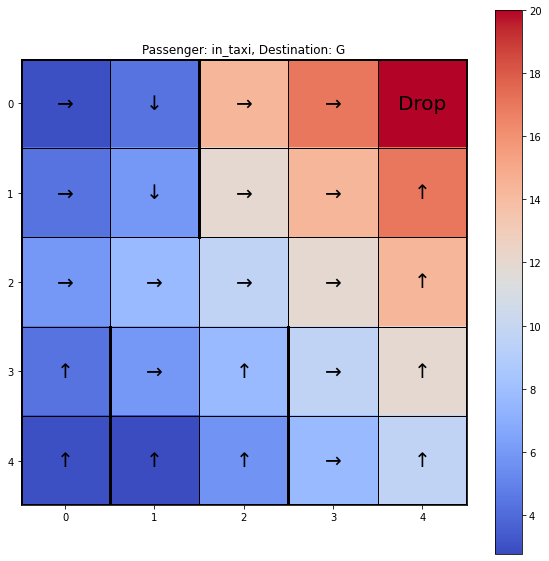

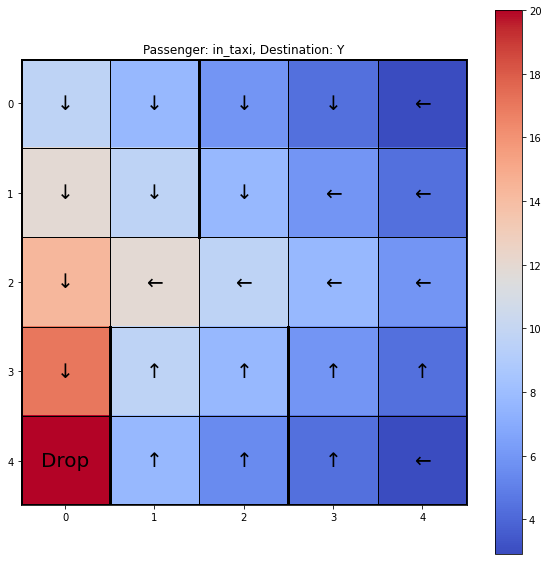

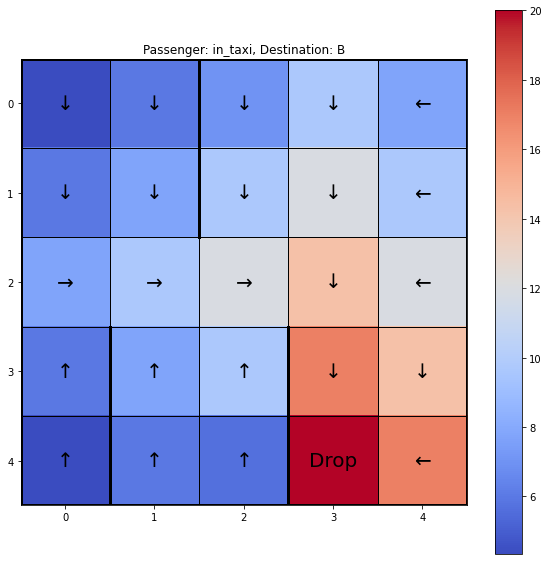

In [23]:
# pass_loc = [0,1,2,3,4] # R, G, Y, B, in_taxi
# dest_loc = [0,1,2,3] # R, G, Y, B
cell_color = {0: 'R', 1: 'G', 2: 'Y', 3: 'B', 4: 'in_taxi'}

Q = np.load("results/intra_option_Q.npy")
# Q = np.load("results/smdp_Q.npy")

for pass_loc in range(5):
    for dest_loc in range(4):
        Q_grid = np.zeros((5, 5))
        optimal_action_grid = np.zeros((5, 5))
        for row in range(5):
            for col in range(5):
                state = env.encode(row, col, pass_loc, dest_loc)
                Q_grid[row, col] = np.max(Q[state])
                max_q_idx = np.argwhere(Q[state] == np.max(Q[state])).flatten()
                optimal_action_grid[row, col] = max_q_idx[-1]
                # optimal_action_grid[row, col] = np.argmax(Q[state])

        plt.figure(figsize=(10, 10))
        plt.imshow(Q_grid, cmap='coolwarm')

        # Add annotations
        for i in range(5):
            for j in range(5):
                action = optimal_action_grid[i, j]
                if action == 0: # put down arrow
                    plt.text(j, i, u'\u2193', color='black', fontsize=20, ha='center', va='center')
                elif action == 1: # put up arrow
                    plt.text(j, i, u'\u2191', color='black', fontsize=20, ha='center', va='center')
                elif action == 2: # put right arrow
                    plt.text(j, i, u'\u2192', color='black', fontsize=20, ha='center', va='center')
                elif action == 3: # put left arrow
                    plt.text(j, i, u'\u2190', color='black', fontsize=20, ha='center', va='center')
                elif action == 4: # put Pick
                    plt.text(j, i, "Pick", color='black', fontsize=20, ha='center', va='center')
                elif action == 5: # put Drop
                    plt.text(j, i, "Drop", color='black', fontsize=20, ha='center', va='center')
                elif action == 6: # put Move_to_R
                    plt.text(j, i, "Go R", color='black', fontsize=20, ha='center', va='center')
                elif action == 7: # put Move_to_G
                    plt.text(j, i, "Go G", color='black', fontsize=20, ha='center', va='center')
                elif action == 8: # put Move_to_Y
                    plt.text(j, i, "Go Y", color='black', fontsize=20, ha='center', va='center')
                elif action == 9: # put Move_to_B
                    plt.text(j, i, "Go B", color='black', fontsize=20, ha='center', va='center')


        plt.axhline(y=-0.5, color='black', linewidth=3)
        plt.axhline(y=4.5, color='black', linewidth=3)
        plt.axvline(x=-0.5, color='black', linewidth=3)
        plt.axvline(x=4.5, color='black', linewidth=3)

        # Add horizontal grid lines
        for i in range(6):
            plt.axhline(y=i-0.5, color='black', linewidth=1)

        # Add vertical grid lines
        for i in range(6):
            plt.axvline(x=i-0.5, color='black', linewidth=1)

        plt.axvline(x=1.5, ymin=0.6, ymax=1, color='black', linewidth=3)
        plt.axvline(x=0.5, ymin=0, ymax=0.4, color='black', linewidth=3)
        plt.axvline(x=2.5, ymin=0, ymax=0.4, color='black', linewidth=3)

        plt.colorbar()
        plt.title(f"Passenger: {cell_color[pass_loc]}, Destination: {cell_color[dest_loc]}")
        # plt.savefig(f'plots/passenger_{cell_color[pass_loc]}_destination_{cell_color[dest_loc]}.png')
        plt.show()
